In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

import tqdm

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d bogdancretu/flower299

100% 1.84G/1.85G [00:19<00:00, 149MB/s]
100% 1.85G/1.85G [00:19<00:00, 100MB/s]


In [9]:
!unzip flower299.zip

Streaming output truncated to the last 5000 lines.
  inflating: Flowers299/WinterJasmine/66bfe36a4d.jpg  
  inflating: Flowers299/WinterJasmine/6715063451.jpg  
  inflating: Flowers299/WinterJasmine/6743b0627d.jpg  
  inflating: Flowers299/WinterJasmine/69796fa61a.jpg  
  inflating: Flowers299/WinterJasmine/69fcea24cd.jpg  
  inflating: Flowers299/WinterJasmine/6a12651555.jpg  
  inflating: Flowers299/WinterJasmine/6a175b1660.jpg  
  inflating: Flowers299/WinterJasmine/6a3ddee1ec.jpg  
  inflating: Flowers299/WinterJasmine/6a78195245.jpg  
  inflating: Flowers299/WinterJasmine/6bdd6c1804.jpg  
  inflating: Flowers299/WinterJasmine/6c16c5ab4b.jpg  
  inflating: Flowers299/WinterJasmine/6d19f622bf.jpg  
  inflating: Flowers299/WinterJasmine/6d232af6e3.jpg  
  inflating: Flowers299/WinterJasmine/6d8d20fd99.jpg  
  inflating: Flowers299/WinterJasmine/6ecb81c55b.jpg  
  inflating: Flowers299/WinterJasmine/6ffdf77eb5.jpg  
  inflating: Flowers299/WinterJasmine/700265f40e.jpg  
  inflating: F

In [10]:
class FlowerResNet(nn.Module):
    def __init__(self, num_classes):
        super(FlowerResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)
        return out


In [11]:
data_path = '/content/Flowers299'
batch_size = 128
num_classes = 299
learning_rate = 0.001
checkpoint_path = '/content/drive/MyDrive/project/res_checkpoint.pth'


In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.RandomRotation(30),  # Randomly rotate the image by 30 degrees
    transforms.ToTensor(),  # Convert the image to a tensor (ensures 3 channels)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [13]:
# Load the dataset from the folder structure
dataset = ImageFolder(data_path, transform=transform)


In [14]:

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [15]:
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the custom model
model = FlowerResNet(num_classes)
model.to(device)

with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = next(iter(train_loader))
    images = images.to(device)  # Move images to the same device as the model
    output = model(images)
    print(output.shape)


torch.Size([128, 299])


In [17]:
print(model)

FlowerResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [18]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters: ", total_params)

Total Parameters:  21438059


In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

In [20]:
start_epoch = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

if os.path.exists(checkpoint_path):
    try:
      checkpoint = torch.load(checkpoint_path)
    except Exception as e:
      checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['val_loss']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']

In [ ]:
num_epochs = 40

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    start_time = time.time()  # Start time for the epoch

    for images, labels in tqdm.tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * total_correct / total_samples

    model.eval()
    val_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * total_correct / total_samples

    scheduler.step(val_loss)

    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Total time taken for the epoch

    # Store the losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Time taken for Epoch {epoch + 1}: {epoch_time:.2f} seconds")

    # Save the model and optimizer state in the checkpoint file
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, checkpoint_path)


100%|██████████| 725/725 [08:19<00:00,  1.45it/s]


Epoch [29/40], Training Loss: 0.8974, Validation Loss: 1.0130
Train Accuracy: 76.15%, Validation Accuracy: 72.52%
Time taken for Epoch 29: 589.79 seconds


100%|██████████| 725/725 [08:19<00:00,  1.45it/s]


Epoch [30/40], Training Loss: 0.8264, Validation Loss: 0.9916
Train Accuracy: 77.90%, Validation Accuracy: 73.50%
Time taken for Epoch 30: 586.55 seconds


100%|██████████| 725/725 [08:21<00:00,  1.45it/s]


Epoch [31/40], Training Loss: 0.7787, Validation Loss: 0.9743
Train Accuracy: 79.07%, Validation Accuracy: 73.68%
Time taken for Epoch 31: 590.59 seconds


100%|██████████| 725/725 [08:21<00:00,  1.45it/s]


Epoch [32/40], Training Loss: 0.7311, Validation Loss: 0.9407
Train Accuracy: 80.29%, Validation Accuracy: 74.76%
Time taken for Epoch 32: 589.05 seconds


100%|██████████| 725/725 [08:20<00:00,  1.45it/s]


Epoch [33/40], Training Loss: 0.6863, Validation Loss: 1.0059
Train Accuracy: 81.40%, Validation Accuracy: 72.59%
Time taken for Epoch 33: 587.92 seconds


100%|██████████| 725/725 [08:19<00:00,  1.45it/s]


Epoch [34/40], Training Loss: 0.6480, Validation Loss: 0.8853
Train Accuracy: 82.41%, Validation Accuracy: 76.14%
Time taken for Epoch 34: 587.15 seconds


100%|██████████| 725/725 [08:18<00:00,  1.45it/s]


Epoch [35/40], Training Loss: 0.6101, Validation Loss: 0.9183
Train Accuracy: 83.51%, Validation Accuracy: 75.32%
Time taken for Epoch 35: 586.23 seconds


100%|██████████| 725/725 [08:20<00:00,  1.45it/s]


Epoch [36/40], Training Loss: 0.5712, Validation Loss: 0.9173
Train Accuracy: 84.56%, Validation Accuracy: 75.51%
Time taken for Epoch 36: 588.02 seconds


100%|██████████| 725/725 [08:17<00:00,  1.46it/s]


Epoch [37/40], Training Loss: 0.5436, Validation Loss: 0.8349
Train Accuracy: 85.25%, Validation Accuracy: 77.61%
Time taken for Epoch 37: 584.96 seconds


100%|██████████| 725/725 [08:19<00:00,  1.45it/s]


Epoch [38/40], Training Loss: 0.5098, Validation Loss: 0.9050
Train Accuracy: 86.22%, Validation Accuracy: 76.04%
Time taken for Epoch 38: 586.17 seconds


100%|██████████| 725/725 [08:18<00:00,  1.45it/s]


Epoch [39/40], Training Loss: 0.4848, Validation Loss: 0.8898
Train Accuracy: 86.79%, Validation Accuracy: 76.26%
Time taken for Epoch 39: 587.73 seconds


100%|██████████| 725/725 [08:18<00:00,  1.45it/s]


Epoch [40/40], Training Loss: 0.4499, Validation Loss: 0.9267
Train Accuracy: 87.84%, Validation Accuracy: 75.30%
Time taken for Epoch 40: 585.24 seconds


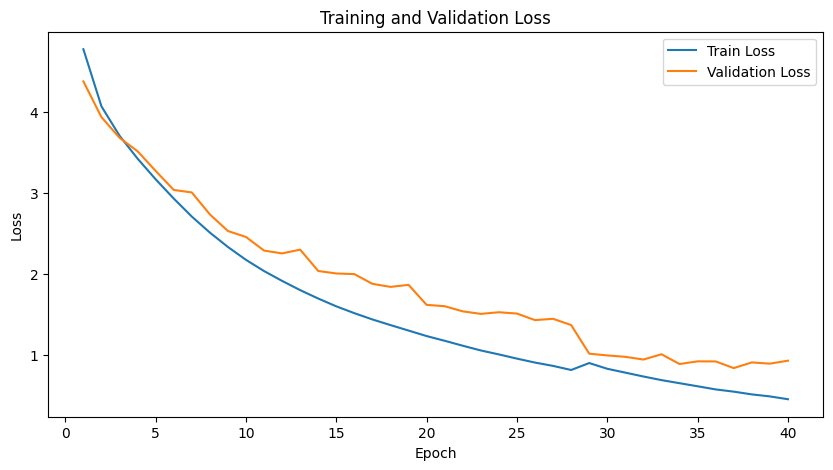

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

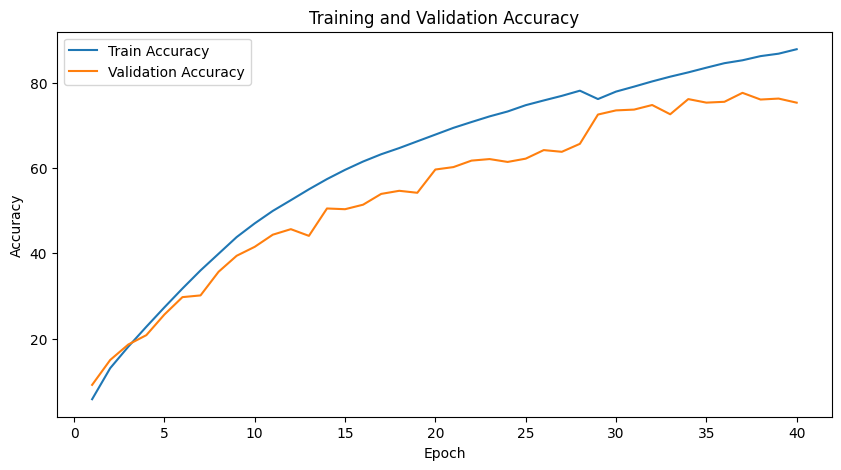

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [32]:
def get_class_names(folder_path):
    class_names = []
    subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]
    class_names = sorted(subfolders)
    return class_names

folder_path = '/content/Flowers299'
class_names = get_class_names(folder_path)
print(class_names)

['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', 'BabyтАЩsBreath', 'BachelorтАЩsButton', 'BalloonFlower', 'Ballota', 'BeeBalm', 'Begonia', 'Bellflower', 'Bergamot', 'Bergenia', 'Billbergia', 'Black-eyedSusan', 'BlanketFlower', 'BlazingStar', 'BleedingHeart', 'Bletilla', 'Blue-eyedGrass', 'Bluebonnets', 'BluestarFlower', 'Borage', 'Bottlebrush', 'Bouvardia', 'Brachyscome', 'Brassica', 'Broom', 'Buttercup', 'ButterflyBush', 'Calceolaria', 'Calendula', 'CaliforniaPoppy', 'CallaLily', 'Camellia', 'Candytuft', 'CannaLily', 'CapeLeadwort', 'CapePrimrose', 'CardinalFlower', 'Carnation', 'Catharanthus', 'Catmint', 'Celosia', 'CerastiumTomentosum', 'Chicory', 'Chionodoxa', 'Chrysanthemum', 'Clarkia', 'Clematis', 'Clover', 'Columbine', 'Coneflower', 'CoralBells', 'CoralVine', 'Coreopsis', 'Cornflower', 'Corydalis', 'Cosmos', 'Cot

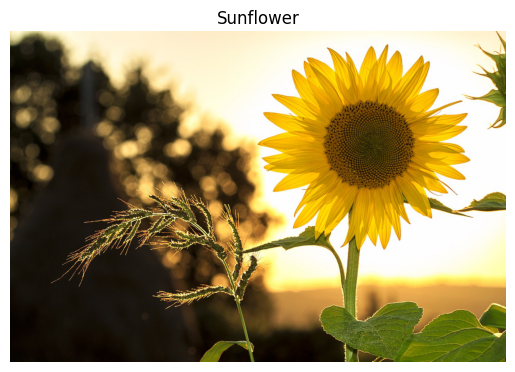

None


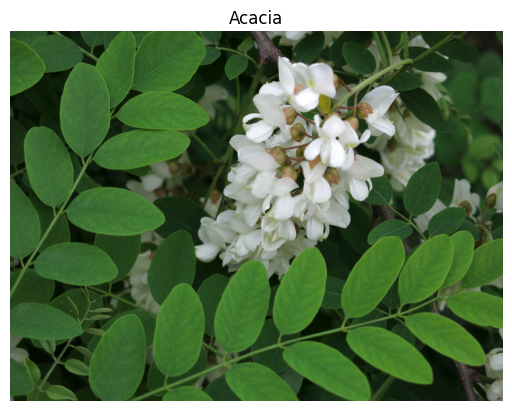

None


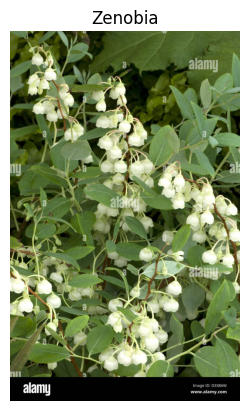

None


In [38]:
from PIL import Image

class_names = ['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', 'BabyтАЩsBreath', 'BachelorтАЩsButton', 'BalloonFlower', 'Ballota', 'BeeBalm', 'Begonia', 'Bellflower', 'Bergamot', 'Bergenia', 'Billbergia', 'Black-eyedSusan', 'BlanketFlower', 'BlazingStar', 'BleedingHeart', 'Bletilla', 'Blue-eyedGrass', 'Bluebonnets', 'BluestarFlower', 'Borage', 'Bottlebrush', 'Bouvardia', 'Brachyscome', 'Brassica', 'Broom', 'Buttercup', 'ButterflyBush', 'Calceolaria', 'Calendula', 'CaliforniaPoppy', 'CallaLily', 'Camellia', 'Candytuft', 'CannaLily', 'CapeLeadwort', 'CapePrimrose', 'CardinalFlower', 'Carnation', 'Catharanthus', 'Catmint', 'Celosia', 'CerastiumTomentosum', 'Chicory', 'Chionodoxa', 'Chrysanthemum', 'Clarkia', 'Clematis', 'Clover', 'Columbine', 'Coneflower', 'CoralBells', 'CoralVine', 'Coreopsis', 'Cornflower', 'Corydalis', 'Cosmos', 'Cotoneaster', 'Crocosmia', 'Crocus', 'CrownImperial', 'CuckooFlower', 'Cyclamen', 'Daffodil', 'Dahlia', 'Daisy', 'Dandelion', 'Daphne', 'Daylily', 'Decumaria', 'Delphinium', 'DesertRose', 'Deutzia', 'Dianella', 'Dianthusbarbatus', 'Diascia', 'Dietes', 'Dill', 'Disa', 'DutchIris', 'Echinops', 'Echium', 'Elder', 'EnglishBluebell', 'Epimedium', 'Eremurus', 'Erica', 'Erigeron', 'Euphorbia', 'Eustoma', 'EveningPrimrose', 'FallCrocus', 'Feverfew', 'Firethorn', 'FlamingKaty', 'FlannelFlower', 'FlaxFlower', 'FloweringDogwood', 'ForgetMeNot', 'Forsythia', 'FourOтАЩclock', 'Foxglove', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Fuchsia', 'Gaillardia', 'Gardenia', 'Gazania', 'Geranium', 'GerberaFlower', 'Gladiolas', 'Goldenrod', 'GrapeHyacinth', 'Guzmania', 'Hawthorn', 'Heather', 'Hebe', 'Helenium', 'Helichrysum', 'Heliotrope', 'Hellebore', 'Hibiscus', 'Holly', 'Hollyhock', 'Honeysuckle', 'Hosta', 'Hyacinth', 'Hydrangea', 'Hyssop', 'IcePlant', 'IcelandPoppy', 'Impatiens', 'IpomoeaLobata', 'Iris', 'Ixia', 'Ixora', 'JacobтАЩsLadder', 'Jasmine', 'JohnnyJumpUp', 'KaffirLily', 'Kalmia', 'KangarooPaw', 'Knautia', 'Kniphofia', 'LadyтАЩsSlipper', 'Laelia', 'Lantana', 'Larkspur', 'Lavatera', 'Lavender', 'LemonVerbena', 'Lewesia', 'Lilac', 'Lily', 'LilyoftheValley', 'Linaria', 'Lotus', 'LoveintheMist', 'Lunaria', 'Lupin', 'Magnolia', 'MalteseCross', 'Mandevilla', 'MargueriteDaisy', 'Marigold', 'Matthiola', 'Mayflower', 'Meconopsis', 'Mimosa', 'MonkтАЩsHood', 'MoonflowerVine', 'Moraea', 'MorningGlory', 'MossRose', 'Narcissus', 'Nasturtium', 'Nemesia', 'Nemophila', 'Neoregelia', 'Nerine', 'NewZealandTeaTree', 'Nierembergia', 'Nolana', 'Oleander', 'Olearia', 'Orchid', 'OrientalLily', 'OrientalPoppy', 'OrnamentalCherry', 'Ornithogalum', 'Osteospermum', 'Oxalis', 'OxeyeDaisy', 'OysterPlant', 'PaintedDaisy', 'Pansy', 'Parodia', 'PassionFlower', 'PeaceLily', 'Pelargonium', 'Penstemon', 'Peony', 'Periwinkle', 'PersianButtercup', 'Petunia', 'Phlox', 'Photinia', 'Physostegia', 'PincushionFlower', 'Pinks', 'Poinsettia', 'Polyanthus', 'Poppy', 'Potentilla', 'PowderPuff', 'QuakerLadies', 'QueenoftheMeadow', 'QueenтАЩsCup', 'Quince', 'RainLily', 'RockRose', 'Rondeletia', 'RoseofSharon', 'Roses', 'Sage', 'SaintJohnтАЩsWort', 'Scaevola', 'ScentedGeranium', 'Scilla', 'Sedum', 'ShastaDaisy', 'Silene', 'Snapdragon', 'Snowdrop', 'Snowflake', 'Soapwort', 'Speedwell', 'Starflower', 'Statice', 'Sunflower', 'SweetPea', 'TeaRose', 'TigerFlower', 'Tithonia', 'TobaccoPlant', 'Trachelium', 'Trillium', 'Triteleia', 'Tritoniacrocata', 'Trollius', 'TrumpetVine', 'Tuberose', 'Tulip', 'UrnPlant', 'Ursinia', 'UvaUrsi', 'Valerian', 'Verbena', 'Viburnum', 'Viola', 'VirginiaCreeper', 'Wallflower', 'Wandflower', 'Waterlilies', 'Watsonia', 'WaxPlant', 'Wedelia', 'Weigela', 'WhirlingButterflies', 'WinterJasmine', 'Winterberry', 'WishboneFlower', 'WoollyViolet', 'Xanthocerassorbifolium', 'Xerophyllum', 'Xylobium', 'Xylosma', 'Yarrow', 'Yellow-eyedGrass', 'YellowArchangel', 'YellowBell', 'Zenobia', 'Zinnia']

def predict_image(image_path, model_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)

    model = FlowerResNet(num_classes=299)
    model.load_state_dict(torch.load(model_path)['model_state_dict'])  # Load the model state_dict from the checkpoint_path

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    flower_name = class_names[predicted.item()]  # Get the flower name corresponding to the predicted class index

    # Show the image with predicted label using matplotlib
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(flower_name)
    plt.show()

sunflower_image_path = '/content/pexels-pixabay-33044.jpg'
Acacia_image_path = '/content/shutterstock_536801548.jpg'
Zenobia_image_path = '/content/Zenobia_image.jpg'
model_path = '/content/drive/MyDrive/project/res_checkpoint.pth'
print(predict_image(sunflower_image_path, model_path))
print(predict_image(Acacia_image_path, model_path))
print(predict_image(Zenobia_image_path, model_path))